<a href="https://colab.research.google.com/github/d9ria/AB-Tests-Practice/blob/main/11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 11

## Общее описание:
Есть данные о такси-компании (uber), которая хочет изучить отток водителей и посмотреть, какие есть различия между водителями, которые покидают сервис, и которые остаются. Нужно сформулировать и протестировать гипотезы, выделить группы водителей, которые наиболее подвержены "оттоку". На основе результатов сделать выводы о том, что можно улучшить в сервисе, чтобы в дальнейшем внести изменения (и после – провести A/B тест и выяснить, стало ли лучше).

### Описание данных

- `city` – город
- `phone` – основное устройство, которое использует водитель
- `signup_date` – дата регистрации аккаунта (`YYYYMMDD`)
- `last_trip_date` – дата последней поездки (`YYYYMMDD`)
- `avg_dist` – среднее расстояние (в милях) за поездку в первые 30 дней после регистрации
- `avg_rating_by_driver` – средняя оценка поездок водителем
- `avg_rating_of_driver` – средняя оценка поездок водителя
- `surge_pct` – процент поездок, совершенных с множителем > 1 (кажется когда большая загруженность и тд)
- `avg_surge` – средний множитель всплеска за все поездки этого водителя
- `trips_in_first_30_days` – количество поездок, которые совершил водитель в первые 30 дней после регистрации
- `luxury_car_user` – TRUE, если пользователь в первые 30 дней использовал премиум-автомобиль
- `weekday_pct` – процент поездок пользователя, совершенных в будние дни


### План

1. **Небольшой препроцессинг:**
    - Посмотрим на данные
2. **Гипотезы, исходя из общей задачи:**
    - Сформулируем предположения, которые будем тестировать
    - Создадим лейбл churn/not_churn
    - Построим графики
    - **Поинт:** только по графикам выводы делать – bad practice, хорошо подкреплять стат. тестами (и стат. тесты есть не только в A/B)
3. **Тестируем гипотезы:**
     - Выбираем гипотезу
     - Выбираем подходящий тест
     - Тестируем
4. **Подводим итоги:**
    - Сформулировать выводы и суммаризировать всё что было
    - Какие действия нужно предпринять разработчикам/бизнесу, чтобы стало лучше? Как можно будет позже провести A/B тестирование? (починить android приложение, возможно таргетить и мотивировать не очень активных водителей, улучшить программу лояльности и бонусов для водителей и тд и тп)



## 1: загружаем
Еще раз список переменных:

- `city` – город
- `phone` – основное устройство, которое использует водитель
- `signup_date` – дата регистрации аккаунта (`YYYYMMDD`)
- `last_trip_date` – дата последней поездки (`YYYYMMDD`)
- `avg_dist` – среднее расстояние (в милях) за поездку в первые 30 дней после регистрации
- `avg_rating_by_driver` – средняя оценка поездок водителем
- `avg_rating_of_driver` – средняя оценка поездок водителя
- `surge_pct` – процент поездок, совершенных с множителем > 1
- `avg_surge` – средний множитель всплеска за все поездки этого водителя
- `trips_in_first_30_days` – количество поездок, которые совершил водитель в первые 30 дней после регистрации
- `luxury_car_user` – TRUE, если пользователь в первые 30 дней использовал премиум-автомобиль
- `weekday_pct` – процент поездок пользователя, совершенных в будние дни


In [7]:
import numpy as np
import pandas as pd
import scipy.stats as ss

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, chi2, mannwhitneyu, shapiro, kruskal
import statsmodels.api as sa
import scikit_posthocs as sp  # sp.posthoc_dunn() для непараметрического аналога anova

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

In [77]:
df = pd.read_csv('churn.csv')

In [78]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [80]:
df.shape

(50000, 12)

In [81]:
df.isna().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
luxury_car_user              0
weekday_pct                  0
dtype: int64

In [82]:
df.nunique()

avg_dist                  2908
avg_rating_by_driver        27
avg_rating_of_driver        37
avg_surge                  115
city                         3
last_trip_date             182
phone                        2
signup_date                 31
surge_pct                  367
trips_in_first_30_days      59
luxury_car_user              2
weekday_pct                666
dtype: int64

In [83]:
df.dtypes

avg_dist                  float64
avg_rating_by_driver      float64
avg_rating_of_driver      float64
avg_surge                 float64
city                       object
last_trip_date             object
phone                      object
signup_date                object
surge_pct                 float64
trips_in_first_30_days      int64
luxury_car_user              bool
weekday_pct               float64
dtype: object

Изменяем тип для дат:


In [84]:
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date)

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   avg_dist                50000 non-null  float64       
 1   avg_rating_by_driver    49799 non-null  float64       
 2   avg_rating_of_driver    41878 non-null  float64       
 3   avg_surge               50000 non-null  float64       
 4   city                    50000 non-null  object        
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   signup_date             50000 non-null  datetime64[ns]
 8   surge_pct               50000 non-null  float64       
 9   trips_in_first_30_days  50000 non-null  int64         
 10  luxury_car_user         50000 non-null  bool          
 11  weekday_pct             50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [86]:
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [87]:
df.describe(include='object')

,city,phone
count,50000,49604
unique,3,2
top,Winterfell,iPhone
freq,23336,34582


In [88]:
df.describe(include='datetime')

<ipython-input-88-41adad5e0539>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.

<ipython-input-88-41adad5e0539>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,last_trip_date,signup_date
count,50000,50000
unique,182,31
top,2014-06-29 00:00:00,2014-01-18 00:00:00
freq,2036,2948
first,2014-01-01 00:00:00,2014-01-01 00:00:00
last,2014-07-01 00:00:00,2014-01-31 00:00:00


In [89]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


## 2: графики, гипотезы и тесты

Создаем лейбл churn – пользователь ушел, если не был активен последние 30 дней (но можно попробовать и другие значения в зависимости от вашей компании/данных)

In [90]:
df.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

In [91]:
df['days_since_last_trip'] = df.last_trip_date.max() - df.last_trip_date

In [92]:
df['days_since_last_trip']

0        14 days
1        57 days
2       175 days
3         2 days
4       108 days
          ...   
49995    26 days
49996   157 days
49997    40 days
49998   167 days
49999    72 days
Name: days_since_last_trip, Length: 50000, dtype: timedelta64[ns]

Преобразуем в int:

In [93]:
df['days_since_last_trip'] = df['days_since_last_trip'].dt.days

In [94]:
df['days_since_last_trip']

0         14
1         57
2        175
3          2
4        108
        ... 
49995     26
49996    157
49997     40
49998    167
49999     72
Name: days_since_last_trip, Length: 50000, dtype: int64

In [95]:
df['churn'] = df.days_since_last_trip.apply(lambda x: 'churn' if x > 30 else 'not_churn')
df[['days_since_last_trip', 'churn']]

,days_since_last_trip,churn
0,14,not_churn
1,57,churn
2,175,churn
3,2,not_churn
4,108,churn
...,...,...
49995,26,not_churn
49996,157,churn
49997,40,churn
49998,167,churn


### churn
– вы куда все пошли?

Видим, что очень много пользователей не использовали сервис в последнем месяце. Нужно разобраться, какие факторы могут влиять на отток водителей

In [96]:
df.churn.value_counts(normalize=True).mul(100)

churn        62.392
not_churn    37.608
Name: churn, dtype: float64

In [97]:
fig = px.histogram(df, x='churn')
fig.show()

Еще лучше – отразим на графике нормализованные значения (сравниваем не сырые числа):

In [98]:
fig = px.histogram(df, x='churn', histnorm='probability density')
fig.show()

### churn & phone

Предположим, что проблема может быть среди юзеров на конкретной платформе:

In [99]:
pd.crosstab(df.churn, df.phone)

phone,Android,iPhone
churn,,
churn,11876,19057
not_churn,3146,15525


In [100]:
fig = px.histogram(df[['churn', 'phone']].dropna(), x='churn',
                   color='phone')
fig.show()

Делать вывод только по графику – не очень хорошо, поэтому проверим нашу гипотезу с помощью статистического теста.

Есть две категориальные переменные → нужен хи-квадрат

- $H_0$: взаимосвязи между переменными нет
- $H_1$: взаимосвязь есть

In [101]:
from scipy.stats import chi2_contingency, chi2

In [102]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.churn, df.phone))

In [103]:
stat, p

(2558.394212267425, 0.0)

Интерпретируем результат:

In [104]:
"""prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')"""

"prob = 0.95\ncritical = chi2.ppf(prob, dof)\nif abs(stat) >= critical:\n    print('Отклоняем H0')\nelse:\n    print('Не отклоняем H0')"

In [105]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


In [106]:
pd.crosstab(df.churn, df.city)

city,Astapor,King's Landing,Winterfell
churn,,,
churn,12306,3767,15123
not_churn,4228,6363,8213


In [107]:
fig = px.histogram(df[['churn', 'city']].dropna(), x='churn',
                   color='city', )
fig.show()

In [108]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.churn, df.city))

In [109]:
stat, p

(3821.5510225559633, 0.0)

Отклоняем H0, взаимосвязь есть

In [110]:
sample_Astapor = df.query("city == 'Astapor'").trips_in_first_30_days.sample(1000, random_state=17)
print(shapiro(sample_Astapor))

ShapiroResult(statistic=0.5414707660675049, pvalue=4.203895392974451e-45)


In [111]:
sample_King = df.query("(city != 'Astapor') & (city != 'Winterfell')").trips_in_first_30_days.sample(1000, random_state=17)
print(shapiro(sample_King))

ShapiroResult(statistic=0.6132168769836426, pvalue=1.6829594556541053e-42)


In [112]:
sample_Winter = df.query("city == 'Winterfell'").trips_in_first_30_days.sample(1000, random_state=17)
print(shapiro(sample_Winter))

ShapiroResult(statistic=0.545579195022583, pvalue=7.006492321624085e-45)


In [122]:
print(kruskal(df.query("city == 'Winterfell'").dropna(),
              df.query("(city != 'Astapor') & (city != 'Winterfell')").dropna(),
              df.query("city == 'Astapor'").dropna()))

KruskalResult(statistic=array([4.87385213e+01, 7.45301295e+02, 5.42623038e+02, 3.30801210e+02,
       4.14440000e+04, 2.04459806e+03, 1.47894715e+02, 8.08218603e+01,
       4.06251171e+02, 2.38424341e+02, 1.37526511e+02, 2.91910574e+01,
       2.04459806e+03, 3.07798646e+03]), pvalue=array([2.60954364e-011, 1.44504069e-162, 1.48219198e-118, 1.47038103e-072,
       0.00000000e+000, 0.00000000e+000, 7.67486333e-033, 2.81680012e-018,
       6.07685850e-089, 1.68582397e-052, 1.36929641e-030, 4.58397697e-007,
       0.00000000e+000, 0.00000000e+000]))


In [127]:
needed_df = df[['city', 'trips_in_first_30_days']]
sp.posthoc_dunn(needed_df, val_col='trips_in_first_30_days', group_col='city', p_adjust='holm')

,Astapor,King's Landing,Winterfell
Astapor,1.000000e+00,1.313616e-09,2.448501e-49
King's Landing,1.313616e-09,1.000000e+00,8.440212e-10
Winterfell,2.448501e-49,8.440212e-10,1.000000e+00


In [128]:
churn = df.query("churn == 'churn'").trips_in_first_30_days
not_churn = df.query("churn == 'not_churn'").trips_in_first_30_days

In [120]:
mannwhitneyu(churn, not_churn)

MannwhitneyuResult(statistic=234767452.0, pvalue=0.0)

<Axes: xlabel='churn', ylabel='trips_in_first_30_days'>

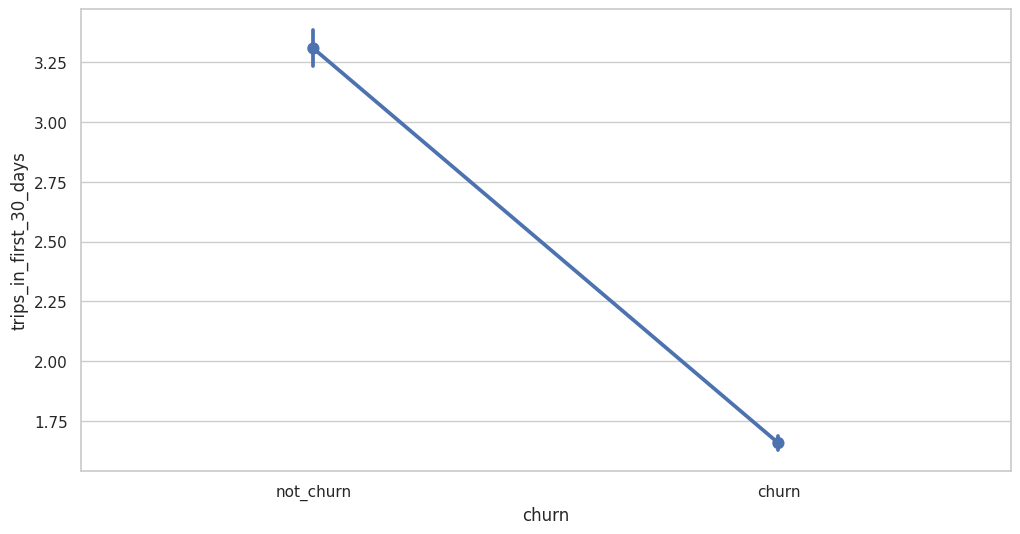

In [121]:
sns.pointplot(x='churn', y='trips_in_first_30_days', data=df)